In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model
import keras as k

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from keras.initializers import GlorotUniform

from matplotlib import pyplot as plt
import seaborn as sns
import scipy

from datetime import datetime

import pickle

from PIL import Image

from custom_class import *

print(f"pd.__version__: {pd.__version__}")
print(f"tf.__version__: {tf.__version__}")

2025-02-27 16:17:36.289556: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 16:17:36.320279: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-27 16:17:36.320333: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-27 16:17:36.321248: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 16:17:36.327699: I tensorflow/core/platform/cpu_feature_guar

pd.__version__: 2.2.3
tf.__version__: 2.15.1


In [2]:
dataset_dir = "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Dataset/machine-learning-in-science-ii-2025"


In [237]:
csv_df = pd.read_csv(os.path.join(dataset_dir, 'training_norm.csv'))
csv_df.set_index('image_id', inplace=True)


1516
8024
0.98437536 0.0
0.98437536 0.0
0.9688736 0.0


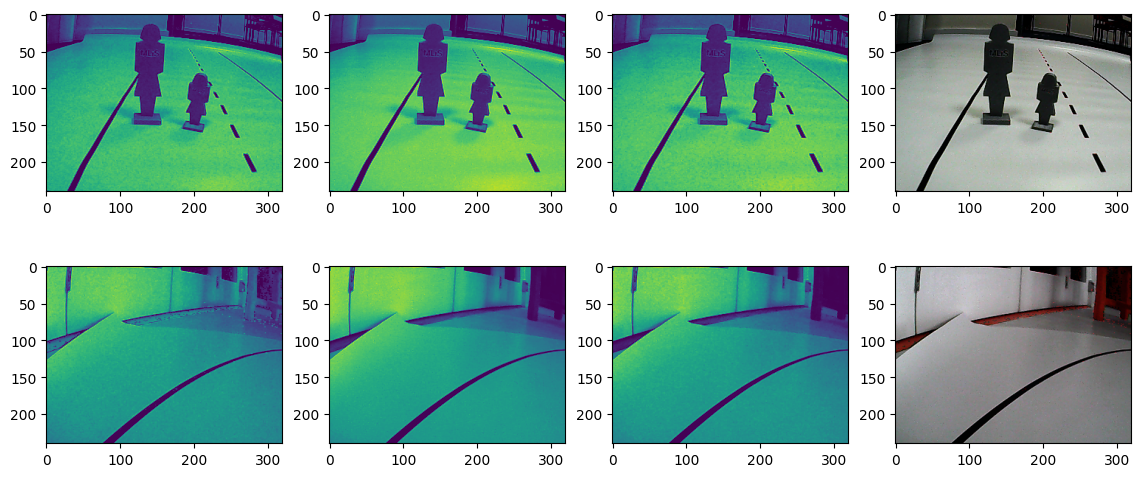

In [596]:
train_dir = os.path.join(dataset_dir, "training_data/training_data")

while True:
    rand_id = np.random.randint(1, 13798)
    if csv_df.loc[rand_id]['speed'] == 0:
       break

# rand_id = 1963
# rand_id = 1166
# rand_id = 5900
print(rand_id)

def process_image(img, enhance=True):
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    r, g, b = tf.split(img, num_or_size_splits=3, axis=-1)
    r_mask = tf.logical_and((r*0.9 > g), (r*0.9 > b))
    g_mask = tf.logical_and((g > r), (g > b))
    b_mask = tf.logical_and((b > r), (b > g))
    r = tf.where(r_mask, r, r**2)
    g = g**2
    b = b**2
    if enhance:
        img = tf.concat([r, g, b], axis=-1)
    return img
 

image_path = os.path.join(train_dir, f"{rand_id}.png")

img = tf.io.read_file(image_path)

img = process_image(img)

fig, ax = plt.subplots(2, 4, figsize=(14, 6))
ax = ax.ravel()

for i in range(3):
  ax[i].imshow(img[:, :, i])

ax[3].imshow(img)


while True:
    rand_id = np.random.randint(1, 13798)
    if csv_df.loc[rand_id]['speed'] == 1:
       break
print(rand_id)

# rand_id = 4716

image_path = os.path.join(train_dir, f"{rand_id}.png")

img = tf.io.read_file(image_path)

img = process_image(img)

for i in range(4, 7):
  ax[i].imshow(img[:, :, i-4])

ax[7].imshow(img)

for i in range(3):
    print(np.max(img.numpy()[i]), np.min(img.numpy()[i]))

In [3]:
image_shape = (240, 320, 3)

base_model = keras.applications.MobileNetV3Large(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape,
    pooling=None,
    include_preprocessing=False, 
)

intermediate_layer_model = Model(
            inputs=base_model.input,
            outputs=base_model.get_layer('expanded_conv_14/depthwise/BatchNorm').output
        )

model = intermediate_layer_model
# model = base_model

2025-02-27 16:17:38.614896: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-27 16:17:38.654540: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-27 16:17:38.654592: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-27 16:17:38.659461: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-27 16:17:38.659530: I external/local_xla/xla/stream_executor

In [4]:
tf.keras.utils.plot_model(
    base_model,
    show_shapes=True,  # Show input/output shapes
    show_layer_names=True,  # Show layer names (e.g., "angle_hidden_2")
    expand_nested=False,  # Keep it flat (no base_model nesting)
    show_layer_activations=True,
    dpi=96,  # Image resolution
)
print("Saved model image: model.png")

Saved model image: model.png


1311
1/1 [==============================] - 1s 525ms/step


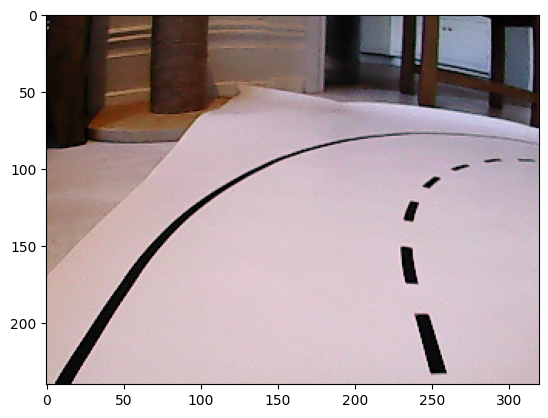

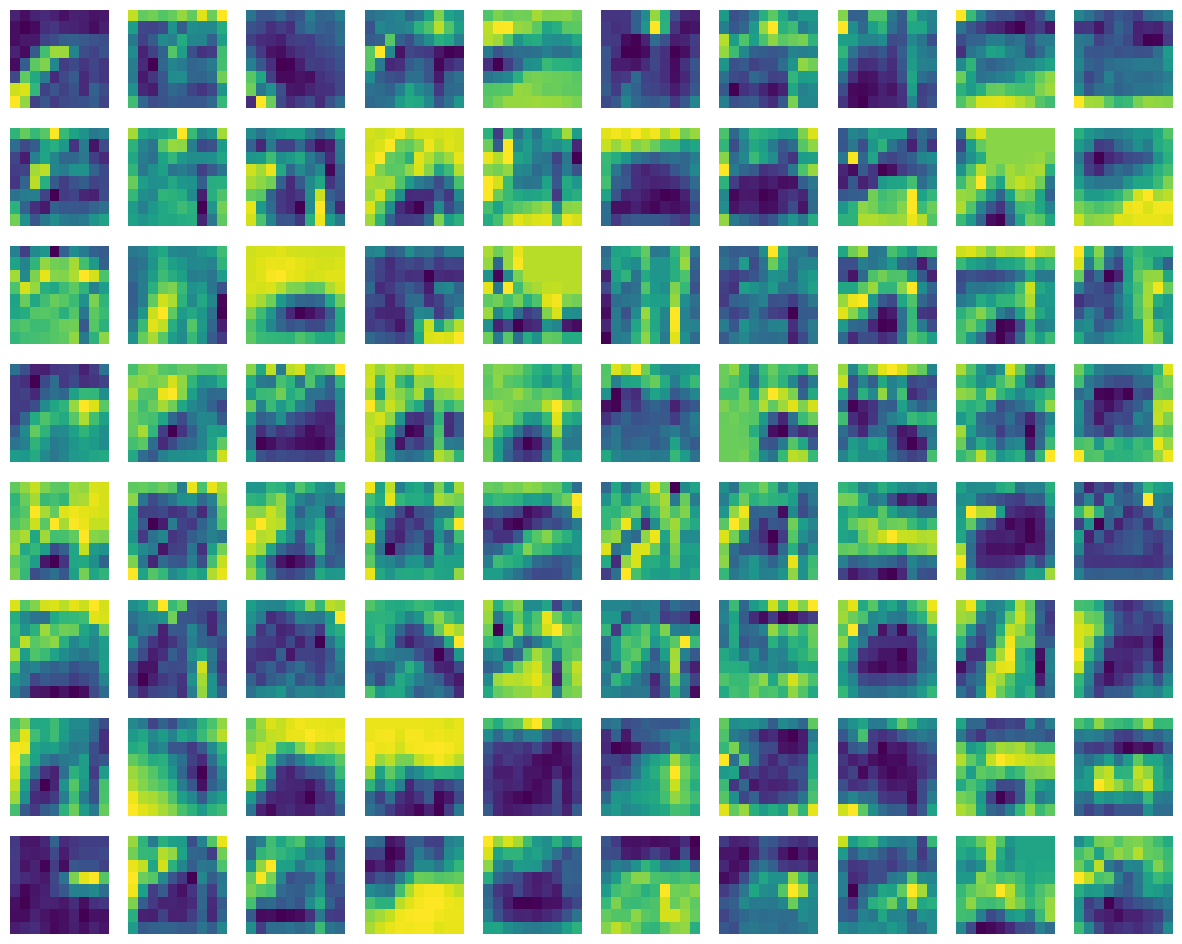

In [145]:
train_dir = os.path.join(dataset_dir, "training_data/training_data")

rand_id = np.random.randint(1, 13798)

print(rand_id)

image_path = os.path.join(train_dir, f"{rand_id}.png")

img = tf.io.read_file(image_path)

img = tf.io.decode_png(img, channels=3)
img = tf.image.convert_image_dtype(img, tf.float32)

plt.imshow(img)

img = img * 2 - 1.0

img = tf.expand_dims(img, axis=0)

pred_raw = model.predict(img)


fig, ax = plt.subplots(8, 10, figsize=(15, 15*0.8))
ax = ax.ravel()

pred = pred_raw[0]

channel_variances = np.var(pred_raw[0, :, :, :], axis=(0, 1))
top_channels = np.argsort(channel_variances)[-80:]

# for i in range(50):
for i in range(80):
    # channel = pred[:, :, top_channels[i]]
    channel = pred[:, :, i]
    ax[i].imshow(channel)
    ax[i].axis("off")
    ax[i].axis("tight")  # gets rid of white border

#   print(max(channel.ravel()))